In [1]:
import pandas as pd
import numpy as np

In [2]:
import src

In [3]:
%pwd

'C:\\Users\\bjk1y13\\OneDrive - University of Southampton\\MH028_UHS_Weather\\4_Analysis\\EDclassification\\notebooks'

In [4]:
def load_pickle_preprocessed_data(path):
    """
    Load pickled data for modelling.
    
    Input
    =====
    path, str, to fodler where data is located.
    
    Output
    ======
    X_train,dataframe, 
    X_test,dataframe, 
    y_train,dataframe, 
    y_test, dataframe, 
    
    """
    #### load each data file
    X_train = pd.read_pickle(path + 'X_train.pkl')
    X_test = pd.read_pickle(path + 'X_test.pkl')
    y_train = pd.read_pickle(path + 'y_train.pkl')
    y_test = pd.read_pickle(path + 'y_test.pkl')
    
    return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = load_pickle_preprocessed_data('../data/processed/v1/')

In [5]:
X_train.shape

(1654, 52)

In [6]:
X_train.head(1)

,EDoccMAX_prevday,callender_DAY(first_EDatt_time),EDmorn_COUNT(EDatt),EDmorn_MEAN(EDatt.wait_time_total),EDmorn_MEAN(EDatt.flag_specreq),EDmorn_MEAN(EDatt.age),EDmorn_MEAN(EDatt.flag_admission),EDmorn_STD(EDatt.wait_time_total),EDmorn_STD(EDatt.flag_specreq),EDmorn_STD(EDatt.age),...,callender_MONTH(first_EDatt_time)_4,callender_MONTH(first_EDatt_time)_5,callender_MONTH(first_EDatt_time)_6,callender_MONTH(first_EDatt_time)_7,callender_MONTH(first_EDatt_time)_8,callender_MONTH(first_EDatt_time)_9,callender_MONTH(first_EDatt_time)_10,callender_MONTH(first_EDatt_time)_11,callender_MONTH(first_EDatt_time)_12,callender_WEEKEND(first_EDatt_time)
0,-0.452744,-1.552923,-1.520733,-2.575791,0.77684,0.788307,-1.017596,-1.371472,-0.44764,0.724071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Instantiate model

# Run CV gridsearch

from sklearn.metrics import classification_report,precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV



def find_best_model(model, grid, Xdata, ydata, plot_label):
    """does gridsearch for model and plots result from """
    my_cv = TimeSeriesSplit(n_splits=5).split(Xdata)
    grid_search = GridSearchCV(model,grid,scoring='f1',cv=my_cv,return_train_score=True)
    grid_search.fit(Xdata,ydata)
    model = grid_search.best_estimator_
    print('CV MODEL RESULTS')
    print(grid_search.best_params_)
    print(pd.DataFrame(grid_search.cv_results_).query('rank_test_score == 1')[['mean_test_score','mean_train_score']])
    
#     plot_model_perf(ydata,Xdata,model,plot_label)

    
    return(grid_search)
    

from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(solver='liblinear',class_weight ='balanced')

grid = {'C':[0.05, 0.1,0.2,0.3,0.5,0.7,1,3,10]}
#grid = {'C':[0.1]}

grid_search = find_best_model(lgr,grid,X_train,y_train,'CV set')
lgr = grid_search.best_estimator_

# grid_search.fit(X_trainT,y_train)
# plot_model_perf(y_test,X_testT,grid_search.best_estimator_,'Test')

# Simple predictions 

In [34]:
y_pred_previousday = y_train.shift(1).fillna(0)

In [38]:
y_pred_weekend = X_train['callender_WEEKEND(first_EDatt_time)']

In [57]:
from src.eval.eval_utils import *
from sklearn.metrics import precision_score, recall_score, confusion_matrix
# import matplotlib.pyplot as plt

class BinClassEvalSimple():
    """ 
    Calcualtes all simple measures on binary classifcation task.
    Suggested use for final evaluation once models have been decided. e.g. running on test set. 
    """
    
    
    def __init__(self, y, y_pred):
        """
        Input
        -----
        Model, sklearn model, (that has had .fit() method called aready).
        X, df/numpy array, containing features
        y, df/numpy array, containing binary target
        """
        #### assign inputs
        self.y = y
        self.label_preds = y_pred
        self.proba_preds = y_pred
            
        #### run evaluation
        self.AUC()
        self.F1()
        self.accuracy()
        self.precision()
        self.recall()
        self.confusion_matrix()
        
        plot = True
        self.plot_title = 'tesT'
        if plot == True:
            self.plot_AUC_PR()
            
        return
    
    def AUC(self):
        "Prints and returns AUC score."
        AUC = roc_auc_score(self.y, self.proba_preds).round(3)
        self.AUC = AUC
        print('AUC: ', AUC) # NOTE: sklearn doc says use prob, if not use decision function.
        return
    
    def F1(self):
        "Prints and returns F1 score."
        F1 = f1_score(self.y, self.label_preds).round(3)
        self.F1 = F1
        print('F1 score: ', F1)
        return
    
    def precision(self):
        "Prints and returns precision score."
        precision = precision_score(self.y, self.label_preds).round(3)
        self.precision = precision
        print('precision: ', precision)
        return
    
    def recall(self):
        "Prints and returns recall score."
        recall = recall_score(self.y, self.label_preds).round(3)
        self.recall = recall
        print('recall: ', recall)
        return
    
    def accuracy(self):
        "Prints and returns accuracy score."
        accuracy = accuracy_score(self.y, self.label_preds).round(3)
        self.accuracy = accuracy
        print('accuracy: ', accuracy)
        return
    
    def confusion_matrix(self):
        "Prints confusion matrix."
        
        
        cm = confusion_matrix(self.y, self.label_preds)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print()
        print('Predicted label')
        print(cm)
        print()
        return
    
    def plot_AUC_PR(self):
        "Plots AUC and Precision-Recall plot as one figures."
        
        precisions, recalls, thresholds = precision_recall_curve(self.y, self.proba_preds)
        print('precisions: ', precisions)
        print('recalls: ', recalls)

        fpr,tpr,thresholds_ROC = roc_curve(self.y, self.proba_preds)
        
        fig,ax = plt.subplots(1,2,figsize=(9,4))
        fig.suptitle(self.plot_title)
        # prec-recall plot
        ax[0].plot(recalls[:-1],precisions[:-1],'g-') #,label='Reca')
        ax[0].set_ylabel('Precision')
        ax[0].set_xlabel('Recall')
        ax[0].legend(frameon=True,loc='center right')
        ax[0].set_ylim([0,1.1])
        # AUC plot
        ax[1].plot(fpr,tpr)
        ax[1].plot([0,1],[0,1],'k--') # 45def line
        ax[1].set_xlabel('F positive rate')
        ax[1].set_ylabel('T positve rate')
        
        return

No handles with labels found to put in legend.


AUC:  0.609
F1 score:  0.326
accuracy:  0.706
precision:  0.25
recall:  0.47

Predicted label
[[1049  354]
 [ 133  118]]

precisions:  [0.15175333 0.25       1.        ]
recalls:  [1.         0.47011952 0.        ]


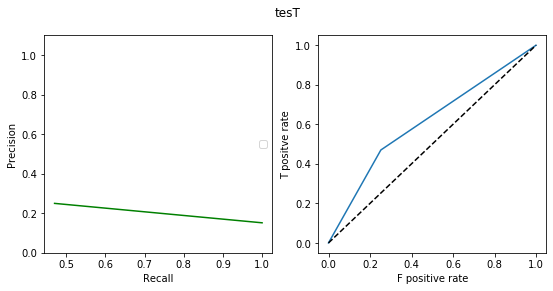

In [58]:
BinClassEvalSimple(y_train, y_pred_weekend)

In [32]:
X_train.groupby('callender_WEEKEND(first_EDatt_time)').count()

,EDoccMAX_prevday,callender_DAY(first_EDatt_time),EDmorn_COUNT(EDatt),EDmorn_MEAN(EDatt.wait_time_total),EDmorn_MEAN(EDatt.flag_specreq),EDmorn_MEAN(EDatt.age),EDmorn_MEAN(EDatt.flag_admission),EDmorn_STD(EDatt.wait_time_total),EDmorn_STD(EDatt.flag_specreq),EDmorn_STD(EDatt.age),...,callender_MONTH(first_EDatt_time)_3,callender_MONTH(first_EDatt_time)_4,callender_MONTH(first_EDatt_time)_5,callender_MONTH(first_EDatt_time)_6,callender_MONTH(first_EDatt_time)_7,callender_MONTH(first_EDatt_time)_8,callender_MONTH(first_EDatt_time)_9,callender_MONTH(first_EDatt_time)_10,callender_MONTH(first_EDatt_time)_11,callender_MONTH(first_EDatt_time)_12
callender_WEEKEND(first_EDatt_time),,,,,,,,,,,,,,,,,,,,,
0.0,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,...,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182
1.0,472,472,472,472,472,472,472,472,472,472,...,472,472,472,472,472,472,472,472,472,472


In [33]:
472/1182

0.3993231810490694